## Imports

In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import pickle
from tqdm.notebook import tqdm

import gym
import matplotlib.pyplot as plt
import numpy as np
import tabulate

from abides_gym_custom_execution_environment import SubGymMarketsCustomExecutionEnv
from sigqlearning_qfunctions import SigQFunction
from sigqlearning_test_execution import test
from sigqlearning_train_execution import train
from sigqlearning_baseline_execution import run_baseline
import utils

## Register the environment as gym environment

In [2]:
# register execution env for gym use 
from gym.envs.registration import register

register(
    id="custom-execution-v0",
    entry_point=SubGymMarketsCustomExecutionEnv,
)

In [3]:
# environment parameters
env_params = dict(
    background_config = "rmsc04",
    mkt_close = "10:06:00",
    timestep_duration = "10s",
    first_interval = "00:05:00",
    observation_interval = "00:00:00",            
    order_fixed_size = 50,
    max_inventory = 1000,
    starting_inventory = 700,
    terminal_inventory_reward = -1., # reward or penalty
    terminal_inventory_mode = 'quadratic', # quadratic, linear, flat
    running_inventory_reward_dampener = 0.6, # 0.6, 1.0
    damp_mode = "asymmetric", # asymmetric
    debug_mode = False
)

# helper function to generate environment with specified parameters
def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(id = "custom-execution-v0", **env_params)
    if seed is not None:
        env.seed(seed)
    return env


In [4]:
# generate the custom execution environment
env = generate_env()

## Training

### Training parameters

In [39]:
# signature parameters
sigq_params = dict(
    sig_depth = 5,
    basepoint = True, 
    initial_bias = 0.01
)

# training parameter
training_params = dict(
    episodes = 200,
    discount = 1.0,
    learning_rate = 1e-6, #1e-4,
    learning_rate_decay = dict(mode=None), #dict(mode='linear', end_value=1e-6, epochs=1000), 
        #dict(mode='exponential', factor=0.998, end_value=1e-07),
    exploration = 'greedy',
    epsilon = 0.02, # 0.8,
    epsilon_decay = dict(mode='linear', end_value=0.0, epochs=200),
    decay_mode = 'episodes',
    debug_mode = None,
    progress_display = 'livelossplot'
)

### Learn a Q-function estimate
Learn a Q-function estimate with Signature-Q-learning. We run 5 different seeds.

**Note**: This code cell takes a long time to run. Would recommend to copy this cell in a python script and let it run in the back with [screen](https://linuxize.com/post/how-to-use-linux-screen/) or [tmux](https://www.hamvocke.com/blog/a-quick-and-easy-guide-to-tmux/) for instance. 

In [26]:
last_Q_function = training_results_dict[0]['intermediate'][-1]

In [ ]:
# number of training runs
n_runs = 1

# dict to store results
training_results_dict = {run : [] for run in range(n_runs)}
training_seeds = {
    run : seed for run, seed 
    in zip(training_results_dict, utils.generate_prime_seeds(n_runs))
}
final_Q_functions = {}

# training runs
runs_pbar = tqdm(training_results_dict.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Training run")
    
    env = generate_env(training_seeds[run])
    sigqfunction = SigQFunction(env, **sigq_params)
    sigqfunction.load_state_dict(last_Q_function)
    training_results_dict[run] = train(env, sigqfunction, **training_params)
    final_Q_functions[run] = sigqfunction.state_dict()
    del sigqfunction, env # for safety in case env.reset() does not work properly

### Save training results

**Note**: Training results are saved under `../results/file_name + today + id`, where `today` is the current date
in the form `%Y%M%d` and `id` an upper case letter to identifiy multiple files saved on the same date.

In [ ]:
file_name = "custom_execution_training"
results_dict=dict(training_results=training_results_dict, final_Q_functions=final_Q_functions,
                  sig_params=sigq_params, training_params=training_params, env_params=env_params)
date_time_id = utils.save_results(results_dict, file_name)

In [8]:
# custom_execution_v0_full_dampening
# 5 runs, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 3,2,5,7,1, quadratic penalty C=-1, basepoint=T, discount=1., damp=1.

# custom_execution_v0_training_no_dampening
# 2 runs, i_0 = 400, oder_size=100, execution action space, with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 1000 epis , epis 1000, seeds (1,2) , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs not fully optimal, first only reduced down to 200, second overshoots then buys again and ends around -100

# custom_execution_v0_training_no_dampening_2
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_3
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to SUBoptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# custom_execution_v0_training_no_dampening_4
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# unstable training, mainly learns to leave inventory untouched

# custom_execution_v0_training_no_dampening_5
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with only one convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# only run 2 learned an acceptable policy, number of episodes to little, reduction from high exploration to low to fast

# INVALID – RUN AGAIN
# custom_execution_v0_training_no_dampening_6
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs a bit suboptimal, first reduces too much end in [-200, 0], second also a little too much but good

# INVALID - RUN AGAIN 
# custom_execution_v0_training_no_dampening_7
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with ?? convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# run 0 it learned a suboptimal policy, run a nearly optimal

# custom_execution_v0_training_no_dampening_8
# 2 runs, i_0 = 400, oder_size=100, execution action space, one run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 7,5 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# first runs optimal, second run shit

# custom_execution_v0_training_no_dampening_9
# 5 runs, i_0 = 400, oder_size=100, execution action space, no run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# shitty shit shit, why?

# custom_execution_v0_training_no_dampening_10
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr exp decay from 1e-4 with 0.997 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn anything, second suboptimal reduces only to 200 high variance, lr decay too fast

# custom_execution_v0_training_no_dampening_11
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr episode exp decay from 1e-4 with 0.998 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn much reduces only 300, second suboptimal reduces reduces a bit too much to -100

# ------ -------
# custom_execution_v0_training_no_dampening_12
# eps_start = 0.8 eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs convergence to almost optimal policy, 2nd a bit better, both overshoot a little at beginning then buy again
# for intermediate -3, testing was even slightly better
# first Q values converge to mean reward with reward window [-200:0]

# custom_execution_v0_training_no_dampening_13
# eps_start = 0.8 eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# even a better than _12, it does not overshoot reduction of inventory, range of terminal inventory is smaller
# first run sometimes sells at end of episode, second run very stable 
# for intermediate -3 testing run_1 was better, run_2 sells to much at episode end, before would be really good
# first Q converges to value a bit below mean reward for both runs

# custom_execution_v0_training_no_dampening_14
# eps_start = 0.8 eps_end = 0.01, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# second run is really good, first run only reduces down to ~200 unfortunately 

# custom_execution_v0_training_no_dampening_15
# eps_start = 0.8 eps_end = 0.01, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1.0, damp=0.
# First run learned nothing, reduces way too much than overshoots buying. Second run ok but in range [0, -200]

# ------ with eps start 0.5 ------
# custom_execution_v0_training_no_dampening_16
# eps_start = 0.5, eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, with no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# no run did learn a good Q estimate
# first Q values did not converge properly

# custom_execution_v0_training_no_dampening_17
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# first run failed to converge, highly unstable in training, second run learned suboptimal policy, that reduces to 300 and only at end to 200
# first Q values did not converge

# ------ with decay mode 'steps' ------
# custom_execution_v0_training_no_dampening_18
# eps_start = 0.5, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, reduced inventory but to a range [-100,100] and overshoot in buying and selling at beginning
# 2nd run did not learn anything useful

# custom_execution_v0_training_no_dampening_19
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run did not learn good policy, reduced halfway through the episode not stable
# 2nd run better, overshoots a little, intermediate at -31 is perfect

# custom_execution_v0_training_no_dampening_20
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, wide range of terminal inventory on [-100,100]
# 2nd run learned good policy, but not particularly better than other cases with episode decay
# BUT perfect convergence of 1st Q value to mean reward !

# custom_execution_v0_training_no_dampening_20a
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50
# 2 runs, i_0 = 400, oder_size=50, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# TO RUN

# custom_execution_v0_training_no_dampening_21
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, lr start 5*1e-5
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 5*1e-5 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_22
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, exp step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr exp step decay from 1e-4 with 0.999985 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_23
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# NO NEED FOR THIS ONE

# custom_execution_v0_training_no_dampening_24
# eps_start = 0.8, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# -------------
# custom_execution_v0_training_no_dampening_100
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50, current_inv as reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_101
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current_inv as reward
# 1 run, i_0 = 400, oder_size=100, execution action space, with ?? convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_102
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, previous_inv as reward with linear terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run learned nothing, 2nd run close to optimal, narrow range, similar to runs with same setup but quadratic terminal reward
# 3rd run with seed = 3 is running # ADD DECRIPTION

# custom_execution_v0_training_no_dampening_103
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current as reward with flat terminal reward and 0 exploration
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs learned a solid policy, however both only reduced to the range [50, 100] and not furhter
# -> not saved

# ************************************************************************************************************************************************************************************************************************************************************************************************************
# custom_execution_v0_training_no_dampening_104
# eps_start = 0.8, eps_mid=0.02, eps_end = 0.0, discount = 1.0, linear episode decay, previous as reward with flat terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl mixed linear 2000 epis, eps_start 0.8, eps_mid=0.02 eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 2,3, flat terminal penalty C=-1, basepoint=T, discount=1., damp=0.


# TO TRY:
# start with i_0=1400, i_max=2000



## Training plots

### Single training run

In [ ]:
# select training run number for plotting
run_id = 4
utils.plot_run_results(training_results_dict, run_id, figsize=None)

### Averaged training results

And save each plot as single file in `..\figures`. Each file name contains `date_time_id` of the corresponding file containing saved training results.

In [ ]:
utils.plot_mean_results(training_results_dict, figsize=None)
#utils.save_mean_results_plots(training_results_dict, date_time_id=date_time_id, 
#                              file_name='custom_execution', show=False)

### Single observation-action history

To gain a more qualitative insight into the policies based on the learned Q-functions, we plot the observastion and action trajectories of a single training episode.

In [ ]:
run_id = 0
episode_id = -1

observation_history = list(training_results_dict[run_id]["observations"][episode_id])
action_history = training_results_dict[run_id]["actions"][episode_id]

utils.plot_observation_action_history(observation_history, action_history, 
                                      episode_id, n_actions=3)

## Testing

To load prior saved training results, set `load_training_results_flag` to True and paste trainings results' file name.

In [35]:
load_training_results_flag = True
from pprint import pp as pprint

if load_training_results_flag:
    date_time_id = '20241008_A'
    file_path = '../results/custom_execution_training_{}.pkl'.format(date_time_id)
    # load training results
    with open(file_path, 'rb') as fin:        
        loaded_training_dict = pickle.load(fin)

    env_params = loaded_training_dict["env_params"]
    sigq_params = loaded_training_dict["sig_params"]
    training_params = loaded_training_dict["training_params"]
    training_results_dict = loaded_training_dict["training_results"]
    final_Q_functions = loaded_training_dict["final_Q_functions"]
    n_runs = len(training_results_dict)
    print("***** training results {} loaded *****".format(date_time_id))
    print('Performed training runs: {}. With parameters:\n'.format(n_runs))
    pprint({key: value for key, value in loaded_training_dict.items() if key not in ('training_results', 'final_Q_functions')})
    del loaded_training_dict

***** training results 20241008_A loaded *****
Performed training runs: 3. With parameters:

{'sig_params': {'sig_depth': 5, 'basepoint': True, 'initial_bias': 0.1},
 'training_params': {'episodes': 2000,
                     'discount': 1.0,
                     'learning_rate': 0.0001,
                     'learning_rate_decay': {'mode': 'linear',
                                             'end_value': 1e-07,
                                             'epochs': 1800},
                     'exploration': 'greedy',
                     'epsilon': 0.8,
                     'epsilon_decay': {'mode': 'linear',
                                       'end_value': 0.02,
                                       'epochs': 1000},
                     'decay_mode': 'episodes',
                     'debug_mode': None,
                     'progress_display': 'livelossplot'},
 'env_params': {'background_config': 'rmsc04',
                'mkt_close': '10:06:00',
                'timestep_duratio

### Test a Q-function estimate

We test the Q-functions learning in training. If an intermediate Q-function estimate saved at some checkpoint instead of the last one for each training run should be tested, set `checkpoint_policy_flag` to True and select a checkpoint.

In [36]:
checkpoint_flag = True
checkpoint = -1

n_test_episodes = 20
test_results_dict = {run : [] for run in range(n_runs)}
seeds = utils.generate_prime_seeds(100, shuffle=True)

runs_pbar = tqdm(test_results_dict.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Test run")

    env = generate_env(seeds[run])
    sigqfunction = SigQFunction(env, **sigq_params)
    state_dict = final_Q_functions[run] if not checkpoint_flag \
        else training_results_dict[run]["intermediate"][checkpoint]
    sigqfunction.load_state_dict(state_dict)
    
    test_results_dict[run] = test(env, sigqfunction, n_test_episodes, debug_mode="info", 
                                  epsilon=0.02)
    del sigqfunction, env # for safety in case env.reset() does not work properly

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Episode 0 | Reward -0.12932 | Inventory 26 | Steps in run 186
Episode 1 | Reward -0.17965 | Inventory 96 | Steps in run 372
Episode 2 | Reward -0.09831 | Inventory -64 | Steps in run 558
Episode 3 | Reward -0.26126 | Inventory 308 | Steps in run 744
Episode 4 | Reward -0.16232 | Inventory 48 | Steps in run 930
Episode 5 | Reward -0.03366 | Inventory 128 | Steps in run 1116
Episode 6 | Reward -0.09817 | Inventory -49 | Steps in run 1302
Episode 7 | Reward -0.71497 | Inventory 354 | Steps in run 1488
Episode 8 | Reward -0.09761 | Inventory 24 | Steps in run 1674
Episode 9 | Reward -0.05392 | Inventory 289 | Steps in run 1860
Episode 10 | Reward -0.19065 | Inventory 390 | Steps in run 2046
Episode 11 | Reward -0.03873 | Inventory -6 | Steps in run 2232
Episode 12 | Reward -0.19803 | Inventory 78 | Steps in run 2418
Episode 13 | Reward -0.32456 | Inventory -11 | Steps in run 2604
Episode 14 | Reward -0.03233 | Inventory -7 | Steps in run 2790
Episode 15 | Reward -0.10909 | Inventory 113 | 

  0%|          | 0/20 [00:00<?, ?it/s]

Episode 0 | Reward 0.02249 | Inventory 49 | Steps in run 186
Episode 1 | Reward -0.07518 | Inventory 42 | Steps in run 372
Episode 2 | Reward -0.03343 | Inventory 72 | Steps in run 558
Episode 3 | Reward -0.12038 | Inventory 298 | Steps in run 744
Episode 4 | Reward -0.17361 | Inventory 229 | Steps in run 930
Episode 5 | Reward -0.10066 | Inventory 26 | Steps in run 1116
Episode 6 | Reward -0.15334 | Inventory 144 | Steps in run 1302
Episode 7 | Reward -0.22516 | Inventory 187 | Steps in run 1488
Episode 8 | Reward -0.10864 | Inventory 96 | Steps in run 1674
Episode 9 | Reward -0.36806 | Inventory 101 | Steps in run 1860
Episode 10 | Reward -0.07898 | Inventory 139 | Steps in run 2046
Episode 11 | Reward -0.12397 | Inventory 130 | Steps in run 2232
Episode 12 | Reward -0.38856 | Inventory 106 | Steps in run 2418
Episode 13 | Reward -0.47714 | Inventory 132 | Steps in run 2604
Episode 14 | Reward -0.31636 | Inventory 125 | Steps in run 2790
Episode 15 | Reward 0.03851 | Inventory 139 | 

  0%|          | 0/20 [00:00<?, ?it/s]

Episode 0 | Reward -0.09880 | Inventory -83 | Steps in run 186
Episode 1 | Reward -0.04597 | Inventory 100 | Steps in run 372
Episode 2 | Reward -0.16253 | Inventory 57 | Steps in run 558
Episode 3 | Reward -0.04860 | Inventory 36 | Steps in run 744
Episode 4 | Reward -0.04033 | Inventory -8 | Steps in run 930
Episode 5 | Reward -0.32267 | Inventory 39 | Steps in run 1116
Episode 6 | Reward -0.07362 | Inventory 156 | Steps in run 1302
Episode 7 | Reward -0.03355 | Inventory 50 | Steps in run 1488
Episode 8 | Reward -0.02448 | Inventory 101 | Steps in run 1674
Episode 9 | Reward -0.30842 | Inventory 20 | Steps in run 1860
Episode 10 | Reward -0.16995 | Inventory 0 | Steps in run 2046
Episode 11 | Reward -0.23665 | Inventory -50 | Steps in run 2232
Episode 12 | Reward -0.05322 | Inventory 7 | Steps in run 2418
Episode 13 | Reward -0.12364 | Inventory 104 | Steps in run 2604
Episode 14 | Reward -0.01572 | Inventory -47 | Steps in run 2790
Episode 15 | Reward 0.00420 | Inventory 50 | Steps

### Save test results

In [14]:
execute_cell_flag = False

if execute_cell_flag:
    file_path = '../results/custom_execution_test_results_{}.pkl'.format(date_time_id)
    with open(file_path, 'wb') as fout:  
        pickle.dump(test_results_dict, fout)

## Test statistics

The following statisitcs are reported for each test run:
- Mean reward and standard deviation
- Mean terminal inventory and standard deviation
- Minimum / maximum inventory in test run
- Mean terminal cash and standard deviation
- First observation value

In [37]:
test_stats = []
cols = ['Mean\nreward', 'Std\nreward', 'Mean terminal\ninventory', 'Std terminal\ninventory',
        'Min terminal\ninventory', 'Max terminal\ninventory', 'Initial\nvalue']
rows = ['Run {}'.format(i) for i in range(n_runs)]

for test_run in test_results_dict.values():
    run_stats = []
    run_stats.append(np.mean(test_run['rewards'])) # mean reward
    run_stats.append(np.std(test_run['rewards'])) # std reward
    run_stats.append(np.mean(test_run['terminal_inventories'])) # mean terminal inventory
    run_stats.append(np.std(test_run['terminal_inventories'])) # std terminal inventory
    run_stats.append(int(np.min(test_run['terminal_inventories']))) # min terminal inventory
    run_stats.append(int(np.max(test_run['terminal_inventories']))) # max terminal inventory
    run_stats.append(test_run['initial_values'][-1])

    test_stats.append(run_stats)
 
print(tabulate.tabulate(test_stats, headers=cols, showindex=rows, floatfmt='.4f'))

           Mean       Std    Mean terminal    Std terminal    Min terminal    Max terminal    Initial
         reward    reward        inventory       inventory       inventory       inventory      value
-----  --------  --------  ---------------  --------------  --------------  --------------  ---------
Run 0   -0.1505    0.1510          92.1000        132.4907             -64             390    -0.1358
Run 1   -0.1854    0.1669         133.9000         68.2758              26             298    -0.1636
Run 2   -0.1237    0.1076          40.8000         73.0353             -85             180    -0.1316


## Test plots

### Single test run and episode

In [ ]:
utils.plot_test_run_results(test_results_dict, run_id=0, ma_window=5, figsize=(6, 4))

### Confidence intervals

In [ ]:
conf_int_rewards, mean_std_error_reward = utils.compute_confidence_intervals(
    test_results_dict, 'rewards'
)
print(f'\nMean std error of mean reward: {mean_std_error_reward:.4f}')
utils.plot_confidence_intervals(conf_int_rewards, 'rewards', figsize=None,
                                save=True, date_time_id=date_time_id)

## First observation value convergence

**Note**: We need to compare trajectory of the first observation value as provided by the Q-function approximations during training, with the average episode reward once all runs are performed. If the reward and the first observation value converge towards the same value, this is an indication that the algorithm has converged. Note, however, that this does not necessariliy mean that the Q-function approximation has converged to the true optimal Q-functions.

### With intermediate Q functions

observe first interval: False
tensor([[[1.0000, 0.7000],
         [0.9946, 0.7000]]])


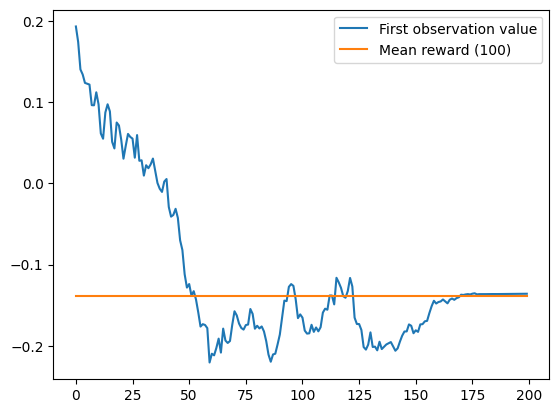

In [38]:
import torch
import math

run_id = 0
mean_epis = 100
env = generate_env()

observation_interval_flag = True if env.observation_interval > 0 else False
print("observe first interval: {}".format(observation_interval_flag))

first_obs_values = []
policy = SigQFunction(env, **sigq_params)

if observation_interval_flag:
    # steps to only observe
    do_nothing_steps = max(1, math.floor(env.observation_interval / env.timestep_duration))
    first_history = list(training_results_dict[run_id]["observations"][0])[0:do_nothing_steps+1]
else:
    # initial observation
    first_history = list(training_results_dict[run_id]["observations"][0])[0:2]
first_history = torch.tensor(
    first_history, requires_grad=False, dtype=torch.float
).unsqueeze(0)
print(first_history)

for state_dict in training_results_dict[run_id]["intermediate"]: 
    policy.load_state_dict(state_dict)    
    policy.eval()
    sig = policy.compute_signature(first_history)  
    first_obs_values.append(max(policy(sig)[0].detach()).item())
    #policy.train()     

plt.plot(first_obs_values)
mean_reward = torch.tensor(training_results_dict[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for _ in range(len(first_obs_values))])
plt.legend(["First observation value", f"Mean reward ({mean_epis})"], loc="best")
plt.show()


### With saved first observation values

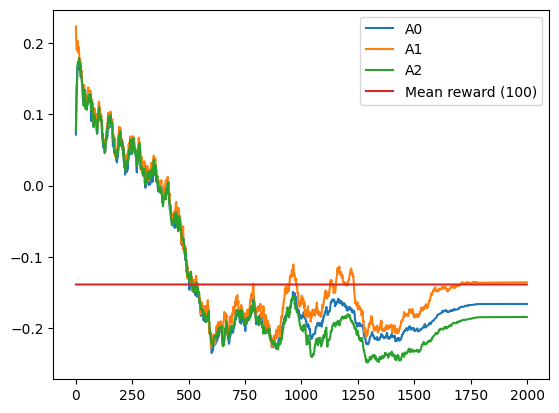

In [39]:
run_id = 0
mean_epis = 100

first_obs_values = torch.stack(training_results_dict[0]['first_Q_values'], dim=0)
plt.plot(first_obs_values)
mean_reward = torch.tensor(training_results_dict[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for _ in range(len(first_obs_values))])
plt.legend(["First observation value", f"Mean reward ({mean_epis})"], loc="best")
plt.legend(["A0","A1", "A2", f"Mean reward ({mean_epis})"], loc="best")
plt.show()

## Baseline policy

The baseline policy sells its inventory as long as the absolute inventory value is above 5% of the maximal inventory and afterwards stops trading until the end of the episode. It is exactly the policy the RL agent is supposed to learn and offers a baseline reward to compare it against.

In [40]:
env = generate_env()
baseline_run = run_baseline(env, 50, debug_mode="info")

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 0 | Reward -0.03097 | Inventory 0 | Steps in run 186
Episode 1 | Reward -0.00520 | Inventory 0 | Steps in run 372
Episode 2 | Reward -0.01503 | Inventory 1 | Steps in run 558
Episode 3 | Reward -0.15878 | Inventory 7 | Steps in run 744
Episode 4 | Reward -0.09906 | Inventory -6 | Steps in run 930
Episode 5 | Reward -0.14972 | Inventory -21 | Steps in run 1116
Episode 6 | Reward -0.06894 | Inventory -6 | Steps in run 1302
Episode 7 | Reward -0.55568 | Inventory -1 | Steps in run 1488
Episode 8 | Reward -0.15702 | Inventory 6 | Steps in run 1674
Episode 9 | Reward -0.20573 | Inventory 17 | Steps in run 1860
Episode 10 | Reward -0.00259 | Inventory 1 | Steps in run 2046
Episode 11 | Reward -0.08113 | Inventory -17 | Steps in run 2232
Episode 12 | Reward -0.13908 | Inventory 6 | Steps in run 2418
Episode 13 | Reward -0.01728 | Inventory -21 | Steps in run 2604
Episode 14 | Reward -0.29768 | Inventory 19 | Steps in run 2790
Episode 15 | Reward -0.05340 | Inventory 0 | Steps in run 2

### Baseline statistics

In [41]:
baseline_stats = []
cols = [
    'Mean\nreward', 'Std\nreward', 'Mean terminal\ninventory', 
    'Std terminal\ninventory', 'Min terminal\ninventory', 'Max terminal\ninventory' 
]

baseline_stats.append(np.mean(baseline_run['rewards'])) # mean reward
baseline_stats.append(np.std(baseline_run['rewards'])) # std reward
baseline_stats.append(np.mean(baseline_run['terminal_inventories'])) # mean terminal inventory
baseline_stats.append(np.std(baseline_run['terminal_inventories'])) # std terminal inventory
baseline_stats.append(int(np.min(baseline_run['terminal_inventories']))) # min terminal inventory
baseline_stats.append(int(np.max(baseline_run['terminal_inventories']))) # max terminal inventory

print(tabulate.tabulate([baseline_stats], headers=cols, floatfmt='.4f'))

    Mean       Std    Mean terminal    Std terminal    Min terminal    Max terminal
  reward    reward        inventory       inventory       inventory       inventory
--------  --------  ---------------  --------------  --------------  --------------
 -0.0816    0.0988           0.3200         12.3052             -24              23


### Baseline plots

In [ ]:
utils.plot_baseline_results(baseline_run, episode_id=-1, ma_window=5, figsize=(6, 4))